In [46]:
import os
import json
from pprint import pprint
import pandas as pd
from statsmodels.stats.proportion import proportion_confint

# List to hold the data from all JSON files
all_json_data = []

# Get the current directory
#current_directory = os.getcwd() + "/result_with_procedures"
current_directory = os.getcwd() + "/result"
def flatten_results(results):
    flattened_results = []
    for key,val in results.items():
        for i,v in enumerate(val):
            flattened_results.append({
                'index':i,
                'benchmark':key,
                'prompt':v[0],
                'success':v[1],
                'captured':repr(v[2][:-1]),
                'code':v[2][-1]
            })
    return flattened_results

# Loop through all files in the current directory
for filename in os.listdir(current_directory):
    if filename.endswith('.json'):
        file_path = os.path.join(current_directory, filename)
        
        # Open and read the JSON file
        with open(file_path, 'r') as file:
            try:
                json_data = json.load(file)

                label = ''.join(filename.split('.')[:-1]).split('_')[-1]

                for key,val in json_data.items():                

                    status = {
                        'model':label
                    }

                    if val['status'] != 'success':
                        continue

                    flattened_results = flatten_results(val['results'])
                    for v in flattened_results:
                        v.update(status)
                        
                    all_json_data+=flattened_results
            except json.JSONDecodeError as e:
                print(f"Error reading {filename}: {e}")

# Now, all_json_data contains the contents of all JSON files

df = pd.DataFrame(all_json_data)

In [47]:
df

,index,benchmark,prompt,success,captured,code,model
0,0,T2,Run experiment to measure dephasing time,False,[],python\nexperiment_dephasing_time = SimpleT1(d...,meta-llama-3-70b-instruct-2
1,1,T2,Implement T2 echo experiment on `dut`,True,[],python\nexperiment_T2Echo = SpinEchoMultiLevel...,meta-llama-3-70b-instruct-2
2,2,T2,Determine qubit T2 echo experiment with free e...,True,[],experiment_SpinEchoMultiLevel = SpinEchoMultiL...,meta-llama-3-70b-instruct-2
3,3,T2,Measure coherence time using T2 echo,True,[],experiment_SpinEchoMultiLevel = SpinEchoMultiL...,meta-llama-3-70b-instruct-2
4,4,T2,Measure T2 dephasing time with echo experiment,True,[],python\nexperiment_SpinEchoMultiLevel = SpinEc...,meta-llama-3-70b-instruct-2
...,...,...,...,...,...,...,...
2395,5,RB1Q,Randomized benchmarking for error characteriza...,True,[],experiment_rb = SingleQubitRandomizedBenchmark...,claude-3-opus-20240229-2
2396,6,RB1Q,Perform single-qubit benchmarking for error rates,True,[],experiment_single_qubit_rb = SingleQubitRandom...,claude-3-opus-20240229-2
2397,7,RB1Q,Implement randomized benchmarking for single q...,True,[],experiment_rb = SingleQubitRandomizedBenchmark...,claude-3-opus-20240229-2
2398,8,RB1Q,Calibrate and measure single-qubit errors with...,True,[],experiment_rb = SingleQubitRandomizedBenchmark...,claude-3-opus-20240229-2


In [48]:
result = df.groupby(['model'])['success'].agg(['mean', 'std'])

# Renaming columns for clarity
result.rename(columns={'mean': 'Average Success Rate', 'std': 'Standard Deviation'}, inplace=True)

['#79afd1', '#79afd1', '#79afd1', '#79afd1', '#2a5893', '#2a5893', '#2a5893', '#79afd1', '#2a5893', '#2a5893']


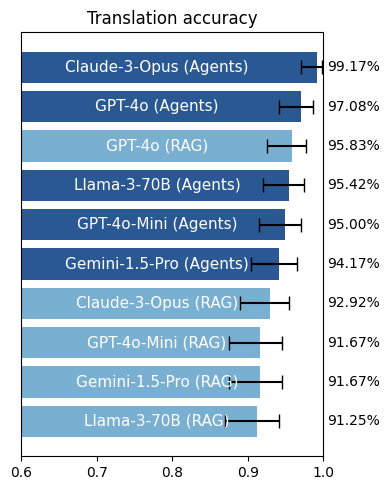

In [51]:
# Adding successes count
df['success_count'] = df['success'].astype(int)

# Grouping by benchmark and model and calculating success counts and total counts
grouped = df.groupby(['model']).agg(
    success_count=('success_count', 'sum'),
    total_count=('success_count', 'count')
)

# Applying the Wilson score confidence interval
grouped['success_rate'] = grouped['success_count'] / grouped['total_count']


# Applying the Wilson score confidence interval
grouped['lower'], grouped['upper'] = zip(*grouped.apply(
    lambda x: proportion_confint(x['success_count'], x['total_count'], method='wilson'), axis=1
))

from matplotlib import pyplot as plt

# Sorting the DataFrame by success_rate in descending order
grouped.sort_values('success_rate', ascending=True, inplace=True)

# Error bars (distance from mean success rate to lower and upper confidence limits)
grouped['error_lower'] = grouped['success_rate'] - grouped['lower']
grouped['error_upper'] = grouped['upper'] - grouped['success_rate']
errors = grouped[['error_lower', 'error_upper']].T.values

label_map = {
    "chatgpt-4o": "GPT-4o",
    "gpt-4o": "GPT-4o",
    "claude-3-opus": "Claude-3-Opus",
    "meta-llama": "Llama-3-70B",
    "gemini": "Gemini-1.5-Pro",
    "gpt-4o-mini": "GPT-4o-Mini",
}

def make_label(x):
    model_name = "error"
    for key in label_map.keys():
        if x.startswith(key):
            model_name = label_map[key]
    if "rag" in x:
        model_name += " (RAG)"
        if "rag-3" in x:
            model_name += " (3)"
        if "rag-4" in x:
            model_name += " (4)"
    else:
        model_name += " (Agents)"
    return model_name

# Plotting
fig, ax = plt.subplots(figsize=(4, 5))
bar_labels = grouped.index.map(make_label)  # Combine benchmark and model for labels
colors = list(map(lambda x: '#79afd1' if 'RAG' in x else '#2a5893', bar_labels))
print(colors)

#plt.grid(True, linestyle='--', which='both', axis='x', alpha=0.7)
bars = ax.barh(bar_labels, grouped['success_rate'], xerr=errors, capsize=5, color=colors)

ax.set_title('Translation accuracy')

# Adding percentage text at the end of bars
for bar in bars:
    width = bar.get_width()
    ax.text(1.005, bar.get_y() + bar.get_height()/2, f'{width:.2%}', va='center')
    
# set the x axis start from 0.6
plt.xlim(0.6, 1)

# hide y axis
ax.get_yaxis().set_visible(False)

# Display the bar_labels on the bar
for i, bar in enumerate(bars):
    ax.text(1-0.22, bar.get_y() + bar.get_height()/2-0.12, f'{bar_labels[i]}', horizontalalignment='center', color='white', fontsize=11)

# tight layout
plt.tight_layout()
#plt.show()
plt.savefig('./translation_success_rate.pdf')

In [50]:
grouped['total_count']

model
meta-llama-3-70b-instruct-rag-2    240
gemini-15-pro-latest-rag-2         240
gpt-4o-mini-rag-2                  240
claude-3-opus-20240229-rag-2       240
gemini-15-pro-latest-2             240
gpt-4o-mini-2                      240
meta-llama-3-70b-instruct-2        240
gpt-4o-2024-08-06-rag-2            240
gpt-4o-2024-08-06-2                240
claude-3-opus-20240229-2           240
Name: total_count, dtype: int64